### 0. Setup

1. Assume we have 2 modalities on the input layer: 

$\sigma$ with $N$ neruons, $\eta$ with $M$ neurons.
    
2. we have $N_c$ neurons on cortical layer, each neurons in one of the following types:

- $p_1$ fraction neurons, purely selective to $\sigma$:

$$h_1 = J^\sigma_1\sigma$$

  - $p_2$ fraction neurons, purely selective to $\eta$:

$$h_2 = J^\eta_1\eta$$

   - $p_3$ fraction neurons, selective to mix of both:

$$h_3 = J^\sigma_2\sigma+ J^\eta_2\eta$$

$p_1 + p_2 + p_3  = 1$
    
3. The total matrix before non-linerity at cortical layer is:

$$h = (h_1,h_2,h_3) = (J^\sigma_1\sigma,J^\eta_1\eta,J^\sigma_2\sigma+ J^\eta_2\eta)$$

To make $h_{ij} \sim \mathcal{N}(0,1)$, we have to normalize connection matrix: 

$$J_1^\sigma \sim \mathcal{N}(0,\frac{1}{N}) \quad J_1^\eta \sim \mathcal{N}(0,\frac{1}{M})$$

$$J_2^\sigma \sim \mathcal{N}(0,\frac{1}{2N}) \quad J_2^\eta \sim \mathcal{N}(0,\frac{1}{2M})$$

4. Add a threshold T to introduce non-linearity

$$m  = \theta(h - T)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
from tqdm import tqdm_notebook

In [3]:
class hetero_forward2(object):
    
    
    
    def __init__(self,N,M,P,K,Nc,p1,p2,p3):
        
        self.dim_mod0 = N  # neurons in first modality
        self.dim_mod1 = M  # neruons in second modality
        self.num_mod0 = P  # independent sample numbers of first modality
        self.num_mod1 = K  # independent sample numbers of second modality
        self.dim_cort = Nc # Neurons on cortical layer
        self.p1 = p1 # fraction of type 1
        self.p2 = p2 # fraction of type 2
        self.p3 = p3 # fraction of type 3
    
    # ------- generate binary random input ------#
    def generate_input(self):
        
        N = self.dim_mod0
        M = self.dim_mod1
        P = self.num_mod0
        K = self.num_mod1
        
        self.data_0 = np.sign(np.random.randn(P, N))
        self.data_1 = np.sign(np.random.randn(K, M))
        
    # ------- generate normalized random connection matrix ------#
    def random_connection(self):
        
        N = self.dim_mod0
        M = self.dim_mod1
        Nc = self.dim_cort
        
        Nc1 = np.int(Nc*self.p1)
        Nc2 = np.int(Nc*self.p2)
        Nc3 = np.int(Nc-Nc1-Nc2)
        
        self.J0_1 = np.random.normal(0,1/np.sqrt(N),size = (N,Nc1))  # Jsigma_1
        self.J1_1 = np.random.normal(0,1/np.sqrt(M),size = (M,Nc2))  # Jeta_1
        self.J0_2 = np.random.normal(0,1/np.sqrt(2*N),size = (N,Nc3))  # Jsigma_2
        self.J1_2 = np.random.normal(0,1/np.sqrt(2*M),size = (M,Nc3))  # Jeta_2
        
        
    # -----fix the sparsity in the cortical layer-----#
    def fix_sparsity(self, a, f=0.5):
        
        '''
        Input: matrix_h
        Return: matrix_m, T
        '''

        v = a.copy()
        threshold = np.sort(v.flatten())[int((1 - f) * v.size)]

        exite = v >= threshold
        inhibit = v < threshold

        v[exite] = 1
        v[inhibit] = 0

        return v,threshold
    
    def feed(self,f=0.5, initial_data = False, return_m = True, initial_J = True):
        
        '''
        if return_m == True: return h,m,T   else: return h 
        '''
        
        P = self.num_mod0
        K = self.num_mod1
        Nc = self.dim_cort
        
        if initial_data: self.generate_input()
        if initial_J: self.random_connection()
        
        
        mix_layer_h = np.zeros((P * K, Nc))
        count = 0
        
        for i in range(P):
            
            for j in range(K):
                
                part1 = np.matmul(self.data_0[i],self.J0_1) 
                part2 = np.matmul(self.data_1[j],self.J1_1)
                part3 = np.matmul(self.data_0[i],self.J0_2) + np.matmul(self.data_1[j],self.J1_2)
                
                mix_layer_h[count,:] = np.concatenate((part1,part2,part3))
                
                count = count + 1
        
        if return_m == True:
            
            after_nonlinear,T = self.fix_sparsity(mix_layer_h,f=f)
            return mix_layer_h, after_nonlinear, T

        else:

            return mix_layer_h

### 0.1 test codes

No noise here

In [125]:
Nc = 1000
N = 100
M = 100
P = 18
K = 20

model_rank1 = hetero_forward2(N,M,P,K,Nc,0.8,0.1,0.1)

h,m,T = model_rank1.feed(0.5,initial_data=True)

print(np.mean(h.flatten()),np.std(h.flatten()))

0.0015840136685304931 0.9977964483886524


### 1. Rank

No noise here.

In [87]:
Nc = 1000
N = 100
M = 100
K = 20

In [88]:
fraction_list = [(0.5,0.5,0),(0.02,0.98,0),(0.3,0.5,0.2),(0.02,0.78,0.2),(0.2,0.3,0.5),(0.01,0.49,0.5),(0,0,1)]

In [89]:
Plist = np.linspace(1,50,20,dtype=np.int)

In [90]:
record1 = np.zeros((7,20))

for i,pset in enumerate(tqdm_notebook(fraction_list)):
    
    p1 = pset[0]
    p2 = pset[1]
    p3 = pset[2]
    
    for j,P in enumerate(Plist):
        
        model_rank1 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
        
        h,m,T = model_rank1.feed(0.5,initial_data=True)
        
        record1[i,j] = np.linalg.matrix_rank(m)

In [38]:
def theo_1(P,K=20):
    
    return P+K-1

def theo_2(P,K=20):
    
    return P*K

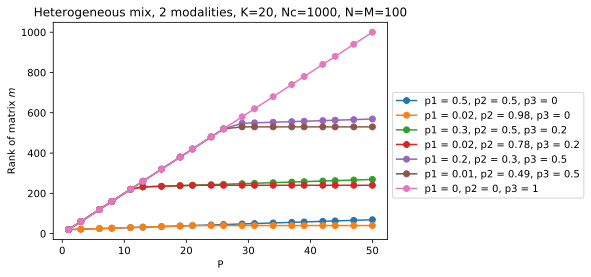

In [95]:
display.set_matplotlib_formats('svg')

for i,pset in enumerate(fraction_list):
    
    p1 = pset[0]
    p2 = pset[1]
    p3 = pset[2]
    
    plt.plot(Plist,record1[i,:],'o-',label='p1 = {}, p2 = {}, p3 = {}'.format(p1,p2,p3))

plt.xlabel('P')
plt.ylabel(r'Rank of matrix $m$')
plt.legend(bbox_to_anchor=[1.0,0.7])

plt.title('Heterogeneous mix, 2 modalities, K=20, Nc=1000, N=M=100')
plt.show()

#### 1.2, rank part2

In [96]:
Nc = 1000
N = 100
M = 100
K = 20
p3_list = np.linspace(0,1,20)

In [99]:
Plist = [5,10,20,40,50,100]

In [100]:
record1_2 = np.zeros((6,20))

for i,P in enumerate(tqdm_notebook(Plist)):
    
    for j,p3 in enumerate(p3_list):
        
        p1 = (1-p3)/2.
        p2 = p1
        
        model_rank1 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
        
        h,m,T = model_rank1.feed(0.5,initial_data=True)
        
        record1_2[i,j] = np.linalg.matrix_rank(m)

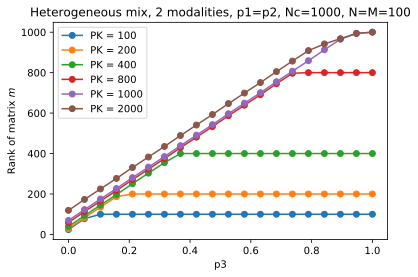

In [102]:
display.set_matplotlib_formats('svg')

for i,P in enumerate(Plist):
    
    plt.plot(p3_list,record1_2[i,:],'o-',label='PK = {}'.format(20*P))

plt.xlabel('p3')
plt.ylabel(r'Rank of matrix $m$')
plt.legend()

plt.title('Heterogeneous mix, 2 modalities, p1=p2, Nc=1000, N=M=100')
plt.show()

#### 三元图

In [105]:
N = 100
M = 100
Nc = 1000

In [106]:
P = 20
K = 20

n = 10  # grid size
record1_t = dict()


for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    model2 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
    
    model2.generate_input()
    
    h,m,T = model2.feed(f)
    
        
    record1_t[(i,j,k)] = np.linalg.matrix_rank(m)

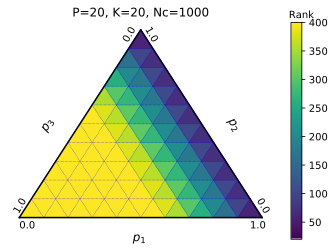

In [108]:
display.set_matplotlib_formats('svg')
figure, tax = ternary.figure(scale=n)
tax.heatmap(record1_t,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(11.1,9.2,'Rank')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'P=20, K=20, Nc=1000',y=1)

In [109]:
P = 40
K = 20

n = 10  # grid size
record1_t2 = dict()


for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    model2 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
    
    model2.generate_input()
    
    h,m,T = model2.feed(f)
    
        
    record1_t2[(i,j,k)] = np.linalg.matrix_rank(m)

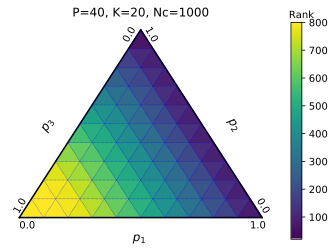

In [110]:
display.set_matplotlib_formats('svg')
figure, tax = ternary.figure(scale=n)
tax.heatmap(record1_t2,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(11.1,9.2,'Rank')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'P=40, K=20, Nc=1000',y=1)

In [111]:
P = 30
K = 10
f = 0.005
n = 10  # grid size
record1_t3 = dict()

for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    model2 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
    
    model2.generate_input()
    
    h,m,T = model2.feed(f)
    
        
    record1_t3[(i,j,k)] = np.linalg.matrix_rank(m)

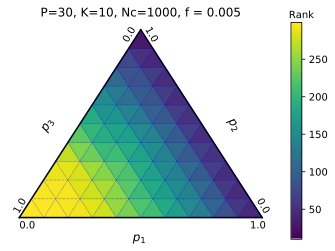

In [112]:
display.set_matplotlib_formats('svg')
figure, tax = ternary.figure(scale=n)
tax.heatmap(record1_t3,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(11.1,9.2,'Rank')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'P=30, K=10, Nc=1000, f = 0.005',y=1)

### 2. Cluster Size

Theoretical part

$$\bar{h}=\left(J_{1}^{\sigma} \bar{\sigma}, J_{1}^{\eta} \bar{\eta}, J_{2}^{\sigma} \bar{\sigma}+J_{2}^{\eta} \bar{\eta}\right)$$

$$h=\left(J_{1}^{\sigma}\sigma, J_{1}^{\eta} \eta, J_2^{\sigma} \sigma+J_{2}^{\eta} \eta\right)$$

$$\langle h \bar{h}\rangle= N_{c} p_{1} \frac{1}{N} \cdot(1-\Delta \sigma)+N_{c} p_{2} \frac{1}{M}(1-\Delta \eta) +N_{c} p_{3}\left[\frac{1}{2 N}(1-\Delta \sigma)+\frac{1}{2 M}(1-\Delta \eta)\right]$$

Set $N = M$: 

$$
\begin{aligned}
\Rightarrow & \frac{N_{c}}{N}\left\{p_{1}(1-\Delta \sigma)+p_{2}(1-\Delta \eta)+\frac{p_{3}}{2}(1-\Delta \sigma)+\frac{p_{3}}{2}(1-\Delta \eta)\right\} \\
&=\frac{N_{c}}{N}[1-(\underbrace{p_{1}+\frac{p_{3}}{2}}_{x})\Delta \sigma  - (\underbrace{p_2+\frac{p_3}{2}}_{1-x})\Delta\eta]\\
&=\frac{N_{c}}{N}[1-x \Delta \sigma-(1-x) \Delta \eta] \\
&=\frac{N_{c}}{N}[1-\Delta \eta+(\Delta \eta-\Delta \sigma) x]
\end{aligned}
$$

Set a benchmark for intuition, let's assume $\Delta \sigma > \Delta \eta$, so $\Delta \eta - \Delta \sigma < 0$:

$$x = p_1+\frac{p_3}{2} \uparrow  \quad \Rightarrow \quad \langle h \bar{h}\rangle \downarrow \quad \Rightarrow \quad \text{the noisy cluster} \ \Delta m \ \text{will be larger (?)} $$

so the intuition from the theoretical discussion of noise amplification is:

$$\text{we want to include less noisy neurons on second layer.}$$

Specially, condider the following two benchmarks:

First, if we have $p_1 = p_2$, we could always find $x = 0.5$, so $p_1,p_2,p_3$ will not change $\langle h \bar{h}\rangle$ (but might change $\Delta m$ here, not sure).

Second, if we have $\Delta \sigma = \Delta \eta$, $\langle h \bar{h}\rangle$ doesn't rely on $x$, or $p_1,p_2,p_3$

**Simulation Part**

cluster size on cortical layer:

$\Delta m = \langle\sum_{j=1}^{N_c}|m^n_j-\bar{m}^n_j|\rangle / [2N_cf(1-f)]$

In [4]:
def cal_delta_m(m,m_center,f=0.5):
    
    Nr,Nc = m.shape
    
    res = np.sum(np.abs(m-m_center))
    
    return res/(2*Nc*Nr*f*(1-f))

def flip_matrix(data,noise_parameter):
    flip_vector = np.sign(np.random.rand(data.shape[0],data.shape[1])-noise_parameter/2.)
    return data*flip_vector

def hebbian_weight(matrix_C,labels,f=0.5): 
    
    # m - f, make mean zero
    norm_C = matrix_C.copy() - f
    
    W = np.matmul(labels,norm_C)
    
    return W

def hebbian_readout(matrix_C,weight,f=0.5):
    
    # m - f, make mean zero
    norm_C = matrix_C.copy() - f
    
    y = np.sign(np.matmul(norm_C,weight))
    
    return y

def readout_error(y,labels):
    
    return((y!=labels).sum()/float(y.size))

In [5]:
N = 100
M = 100
P = 20
K = 20 
Nc = 1000

In [6]:
test = hetero_forward2(N,M,P,K,Nc,0.5,0.5,0)

test.generate_input()

h,m,T = test.feed(0.5)

m_center = m.copy()

center_0 = test.data_0.copy()

center_1 = test.data_1.copy()

test.data_0 = flip_matrix(center_0,0.5)
test.data_1 = flip_matrix(center_1,0.5)

h,m,T = test.feed(f=0.5,initial_J=False)

cal_delta_m(m,m_center,0.5)

0.6714

In [5]:
from ternary.helpers import simplex_iterator
import ternary
from scipy.special import comb, perm

In [6]:
N = 100
M = 100
P = 20
K = 20 
Nc = 1000

In [27]:
delta_sigma=0.4
delta_eta = 0.1
f = 0.5
repeat_num = 10

n = 10  # grid size
record2 = dict()


for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    model2 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
    
    model2.generate_input()
    
    h,m,T = model2.feed(f)
    
    m_center = m.copy()
    
    center_0 = model2.data_0.copy()
    center_1 = model2.data_1.copy()
    
    temp_dm_record = np.zeros(repeat_num)
    
    for repeat in range(repeat_num):
        
        model2.data_0 = flip_matrix(center_0,delta_sigma)
        model2.data_1 = flip_matrix(center_1,delta_eta)
        
        h,m,T = model2.feed(f,initial_J=False)
        
        temp_dm_record[repeat] = cal_delta_m(m,m_center,f) 
        
    record2[(i,j,k)] = np.mean(temp_dm_record)

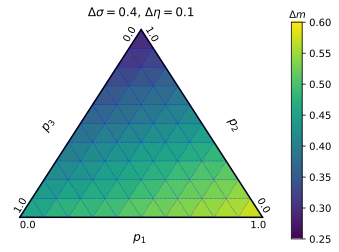

In [95]:
display.set_matplotlib_formats('svg')
figure, tax = ternary.figure(scale=n)
tax.heatmap(record2,scale=n,vmin=0.25,vmax=0.6)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(11.1,9.2,r'$\Delta m$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \sigma = 0.4$, $\Delta \eta = 0.1$',y=1)

In [92]:
delta_sigma=0.3
delta_eta = 0.3
f = 0.5
repeat_num = 20

n = 10  # grid size
record2_1 = dict()


for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    model2 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
    
    model2.generate_input()
    
    h,m,T = model2.feed(f)
    
    m_center = m.copy()
    
    center_0 = model2.data_0.copy()
    center_1 = model2.data_1.copy()
    
    temp_dm_record = np.zeros(repeat_num)
    
    for repeat in range(repeat_num):
        
        model2.data_0 = flip_matrix(center_0,delta_sigma)
        model2.data_1 = flip_matrix(center_1,delta_eta)
        
        h,m,T = model2.feed(f,initial_J=False)
        
        temp_dm_record[repeat] = cal_delta_m(m,m_center,f) 
        
    record2_1[(i,j,k)] = np.mean(temp_dm_record)

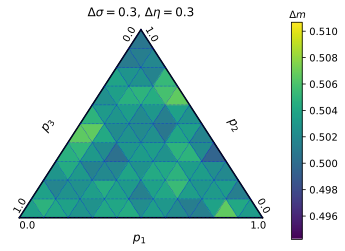

In [97]:
display.set_matplotlib_formats('svg')
figure, tax = ternary.figure(scale=n)
tax.heatmap(record2_1,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(11.1,9.2,r'$\Delta m$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \sigma = 0.3$, $\Delta \eta = 0.3$',y=1)

In [98]:
delta_sigma=0.5
delta_eta = 0.3
f = 0.5
repeat_num = 20

n = 10  # grid size
record2_2 = dict()


for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    model2 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
    
    model2.generate_input()
    
    h,m,T = model2.feed(f)
    
    m_center = m.copy()
    
    center_0 = model2.data_0.copy()
    center_1 = model2.data_1.copy()
    
    temp_dm_record = np.zeros(repeat_num)
    
    for repeat in range(repeat_num):
        
        model2.data_0 = flip_matrix(center_0,delta_sigma)
        model2.data_1 = flip_matrix(center_1,delta_eta)
        
        h,m,T = model2.feed(f,initial_J=False)
        
        temp_dm_record[repeat] = cal_delta_m(m,m_center,f) 
        
    record2_2[(i,j,k)] = np.mean(temp_dm_record)

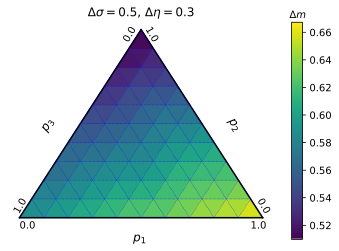

In [99]:
display.set_matplotlib_formats('svg')
figure, tax = ternary.figure(scale=n)
tax.heatmap(record2_2,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(11.1,9.2,r'$\Delta m$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \sigma = 0.5$, $\Delta \eta = 0.3$',y=1)

### 3.readout_error

In [6]:
N = 100
M = 100
Nc = 1000

In [100]:
P = 20
K = 20
delta_sigma=0.4
delta_eta = 0.1
f = 0.5
repeat_num = 100

n = 10  # grid size
record3_1 = dict()


for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):
    
    p1 = i / float(n)
    p2 = j / float(n)
    p3 = k / float(n)
    
    model2 = hetero_forward2(N,M,P,K,Nc,p1,p2,p3)
    
    model2.generate_input()
    labels = np.sign(np.random.randn(P*K))
    
    h,m,T = model2.feed(f)
    
    m_center = m.copy()
    
    W_m = hebbian_weight(m,labels,f=f)
    
    center_0 = model2.data_0.copy()
    center_1 = model2.data_1.copy()
    
    temp_error_record = np.zeros(repeat_num)
    
    for repeat in range(repeat_num):
        
        model2.data_0 = flip_matrix(center_0,delta_sigma)
        model2.data_1 = flip_matrix(center_1,delta_eta)
        
        h,m_noise,T = model2.feed(f,initial_J=False)
        
        y_m_noise = hebbian_readout(m_noise,W_m,f=f)
        
        temp_error_record[repeat] = readout_error(y_m_noise,labels)
        
    record3_1[(i,j,k)] = np.mean(temp_error_record)

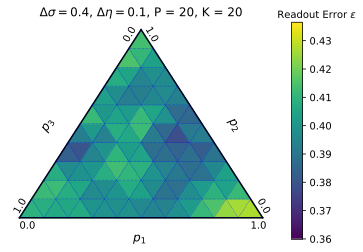

In [104]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(record3_1,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \sigma = 0.4$, $\Delta \eta = 0.1$, P = 20, K = 20',y=1)